# Linking transcriptome and connectome via graph matching
> A simple attempt to see if one 'ome can be aligned to the other 'ome

- toc: true
- badges: false
- categories: [pedigo, graspologic]
- hide: true
- search_exclude: true

In [1]:
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

from graspologic.match import GraphMatch
from graspologic.plot import heatmap
from graspologic.simulations import er_corr
from src.io import savefig
from src.visualization import set_theme

set_theme()


FNAME = os.path.basename(__file__)[:-3]


def stashfig(name, **kws):
    savefig(name, foldername=FNAME, save_on=True, **kws)


data_dir = Path("maggot_models/data/raw/BP_Barabasi_Share/ScRNAData/")

sequencing_loc = data_dir / "Celegans_ScRNA_OnlyLabeledNeurons.csv"
sequencing_df = pd.read_csv(sequencing_loc, skiprows=[1])
sequencing_df = sequencing_df.pivot(
    index="genes", columns="neurons", values="Count"
).fillna(0)

class_map_loc = data_dir / "Labels2_CElegansScRNA_onlyLabeledNeurons.csv"
class_map_df = pd.read_csv(class_map_loc)

connectome_loc = data_dir / "scRNAClassConnectome.csv"
adj_df = pd.read_csv(connectome_loc, index_col=None, header=None)
adj = adj_df.values

label_loc = data_dir / "Connectome_scRNAClassDescriptors.csv"
label_df = pd.read_csv(label_loc)
labels = label_df["Var2"].map(lambda x: x.strip("'"))


## The data

### scRNAseq
 The single cell RNA sequencing data can be thought of as a matrix
 $X \in \mathbb{R}^{G \times N}$ where $G$ is the number of genes that were measured in
 the experiment and $N$ is the number of neurons. Each element in $X$ is a positive integer
 representing the number of times that gene was measured in each neuron.

 Note that here we are primarily concerned with *neuron classes* a.k.a. cell types. The
 goal is to see if we can match neurons in the scRNAseq data to their corresponding
 cell type in the connectome. Multiple neurons from each of the $C$ classes are measured
 in the scRNAseq data - that is, anywhere between ~10 - 6,000 rows of $X$ could
 correspond to neurons from a single cell type.

In [2]:
print(f"Number of genes measured: {sequencing_df.shape[0]}")
print(f"Number of neurons measured: {sequencing_df.shape[1]}")


Number of genes measured: 20092
Number of neurons measured: 43308


### Connectome data
 The connectome is concensed to a cell type connectome, that is, an adjacency matrix
 $A \in \mathbb{R}^{C \times C}$ representing how probably a connection is between each
 cell type.

 Below I just plot $A$, sorting by cell type

<AxesSubplot:title={'center':'Class connectome ($A$)'}>

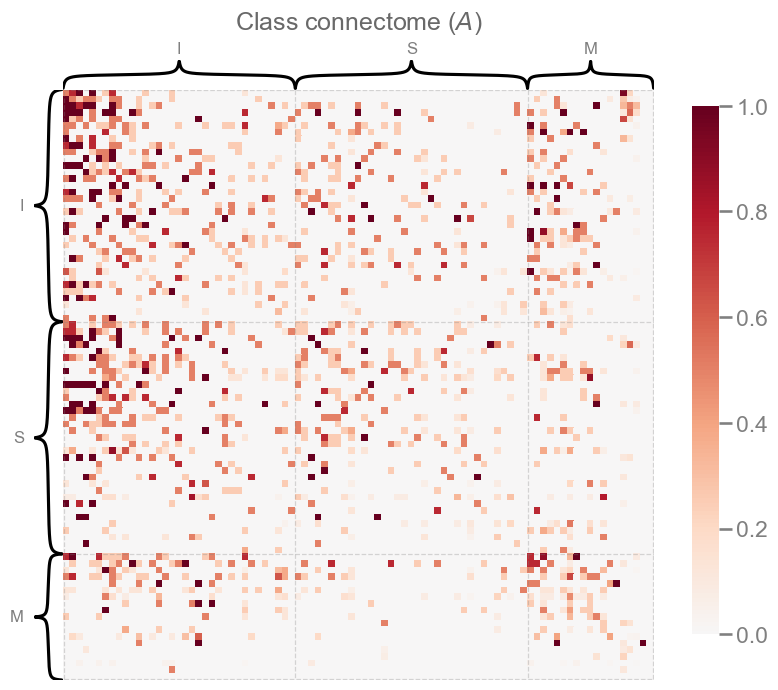

In [3]:

heatmap(
    adj,
    inner_hier_labels=labels,
    sort_nodes=True,
    title=r"Class connectome ($A$)",
    hier_label_fontsize=12,
)


## Matching transcriptome correlations to the connectome
 The experiment I ran goes as follows:

 1. Uniformly at random, sample 1 neuron from each class to get
 $X_{sub} \in \mathbb{R}^{G \times 89}$.
 2. Compute the correlation between columns of $X_{sub}$, yielding
 a $89 \times 89$ correlation matrix $S$.
 3. Run graph matching between $A$ and $S$.
    - Parameters of the graph matching: initialized at the barycenter,
      best of 50 initializations for each trial, maximum of 30 iterations.
 4. Repeat 1 - 3 100 times.
 5. Compute a "confusion matrix" of sorts between neuron classes. The rows and columns
 represent the neuron classes, and each element says how often (out of the 100 trials)
 a neuron in class $i$ was matched to a neuron in class $j$.

 If the matching works well, then the diagonal of that matrix should be heavy.

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]
13.909761190414429 elapsed
Saved figure to maggot_models/notebooks/outs/195.0-BDP-gene-to-connectome/figs/confusion-mat.png


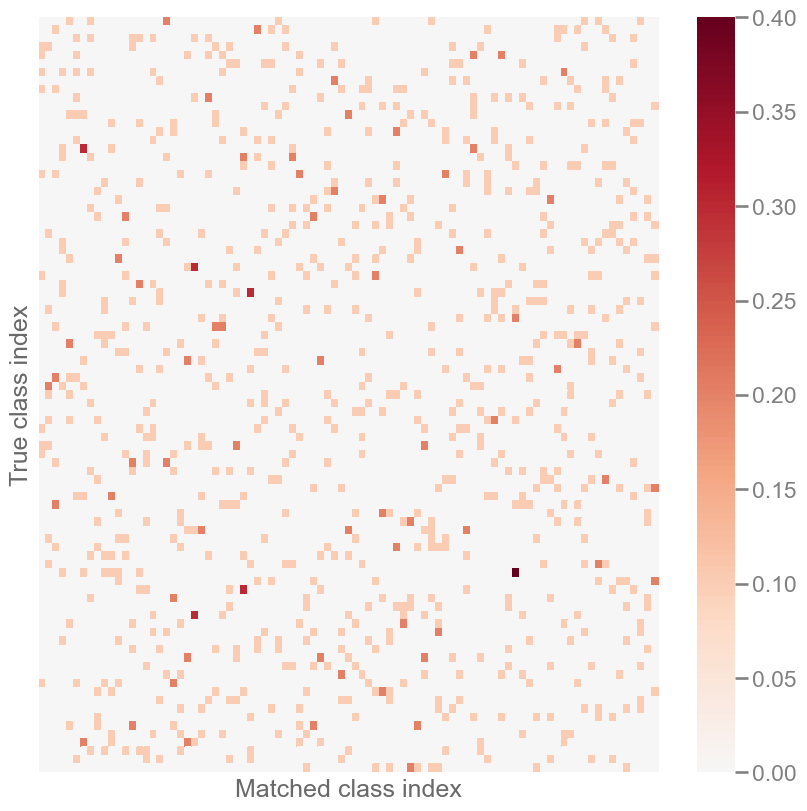

In [4]:
n_per_class = 1  # how many neurons from each class to sample
n_trials = 10
all_perm_inds = []
currtime = time.time()
for i in tqdm(range(n_trials)):
    neuron_sample = class_map_df.groupby("CellTypeIndex").sample(n=n_per_class)
    subset_sequencing_df = sequencing_df[neuron_sample["OldIndices"]]
    corr_mat = pairwise_distances(subset_sequencing_df.T.values, metric="correlation")
    gm = GraphMatch(n_init=50, init="barycenter")
    perm_inds = gm.fit_predict(corr_mat, adj_df.values)
    # perm_inds = gm.fit_predict(A, B)
    all_perm_inds.append(perm_inds)
print(f"{time.time() - currtime} elapsed")

n_classes = len(adj_df)
conf_mat = np.zeros((n_classes, n_classes))
for perm_inds in all_perm_inds:
    conf_mat[np.arange(n_classes), perm_inds] += 1
conf_mat /= n_trials

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(conf_mat, ax=ax, cmap="RdBu_r", center=0)
ax.set(ylabel="True class index", xlabel="Matched class index", xticks=[], yticks=[])
stashfig("confusion-mat")


## Addendum: showing what would happen in this figure if GM works well

100%|██████████| 100/100 [00:52<00:00,  1.92it/s]
Saved figure to maggot_models/notebooks/outs/195.0-BDP-gene-to-connectome/figs/corr-er-confusion-mat.png


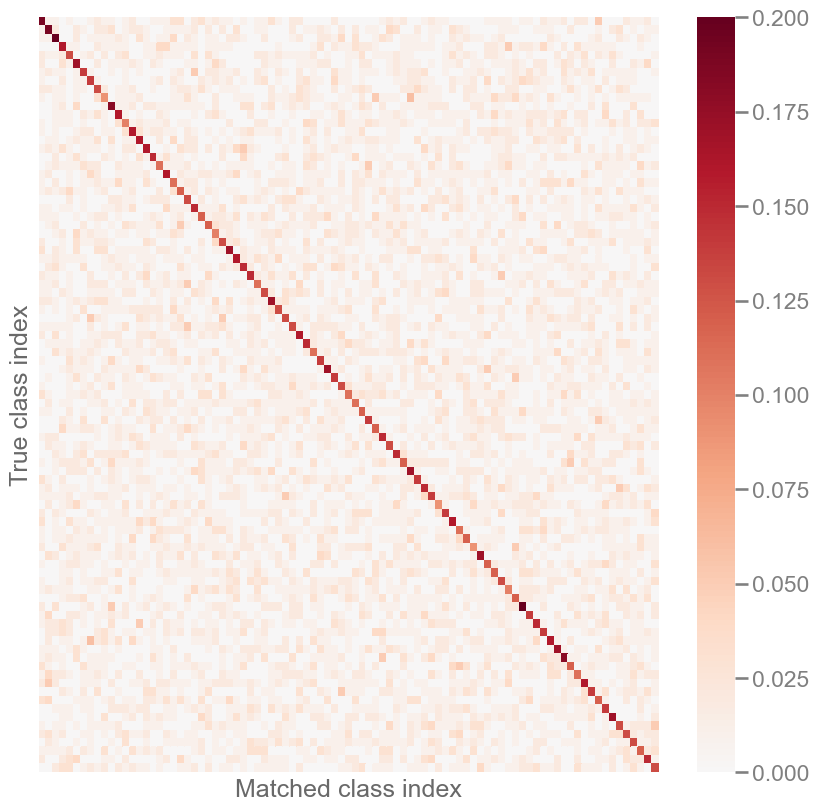

In [5]:
n_trials = 100
all_perm_inds = []
for i in tqdm(range(n_trials)):
    # sample some highly correlated matrices
    A, B = er_corr(n_classes, 0.7, 0.99)
    gm = GraphMatch(n_init=50, init="barycenter")
    perm_inds = gm.fit_predict(A, B)
    all_perm_inds.append(perm_inds)

conf_mat = np.zeros((n_classes, n_classes))
for perm_inds in all_perm_inds:
    conf_mat[np.arange(n_classes), perm_inds] += 1
conf_mat /= n_trials

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(conf_mat, ax=ax, cmap="RdBu_r", center=0)
ax.set(ylabel="True class index", xlabel="Matched class index", xticks=[], yticks=[])
stashfig("corr-er-confusion-mat")
